In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 게임 상수 정의
SCISSORS = 0  # 가위
ROCK = 1      # 바위
PAPER = 2     # 보

In [87]:
# Policy Network 정의
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.fc(x)

In [88]:
# 게임 결과 계산 함수
def get_reward(my_action, opponent_action):
    if my_action == opponent_action:
        return 0  # 무승부
    elif (my_action == SCISSORS and opponent_action == PAPER) or \
         (my_action == ROCK and opponent_action == SCISSORS) or \
         (my_action == PAPER and opponent_action == ROCK):
        return 1  # 승리
    else:
        return -1  # 패배

In [89]:
# 상대방이 항상 같은 선택을 하는 전략
class ConstantOpponent:
    def __init__(self, constant_action):
        self.action = constant_action
    
    def get_action(self):
        return self.action

In [90]:
#상대방 선택 카운트하는 전략
class EpisodeCountingOpponent:
    def __init__(self):
        self.agent_action_history = []  # 에이전트가 지금까지 낸 패
        self.opponent_action_history = []    # 내가 낸 패

    def get_action(self):
        if not self.agent_action_history:
            # 에이전트 행동 기록이 없으면 랜덤
            action = np.random.choice([SCISSORS, ROCK, PAPER])
        else:
            # 가장 많이 낸 행동을 찾음
            counter = Counter(self.agent_action_history)
            most_common_action, _ = counter.most_common(1)[0]
            # 그걸 이기는 패를 선택
            action = (most_common_action + 1) % 3
            
        self.opponent_action_history.append(action)
        return action

    def observe(self, agent_action):
        self.agent_action_history.append(agent_action)

    def reset(self):
        self.agent_action_history = []
        self.opponent_action_history = []

In [91]:
#상대방 완전 무작위
class UniformRandomOpponent:
    def get_action(self):
        return np.random.choice([SCISSORS, ROCK, PAPER])

In [92]:
# Policy Gradient 학습 함수
def train_policy_gradient(policy_net, opponent, num_episodes=1000, learning_rate=0.01):
    policy_net = PolicyNetwork()  # 각 전략마다 새로운 PolicyNetwork 생성
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    rewards = []  #그래프 출력위한 reward 저장
    for episode in range(num_episodes):
        # 상대방의 행동
        opponent_action = opponent.get_action()
        
        # 현재 상태 (one-hot encoding)
        state = torch.zeros(3)
        state[opponent_action] = 1
        
        # 정책에 따른 행동 선택
        action_probs = policy_net(state)
        action = torch.multinomial(action_probs, 1).item()
        
        # 에이전트의 행동을 관찰/기록 (observe 메서드가 있는 경우에만)
        if hasattr(opponent, 'observe'):
            opponent.observe(action)
        
        # 보상 계산
        reward = get_reward(action, opponent_action)
        rewards.append(reward)
        
        # Policy Gradient 업데이트
        optimizer.zero_grad()
        loss = -torch.log(action_probs[action]) * reward
        loss.backward()
        optimizer.step()

        if (episode + 1) % 500 == 0:
            print(f"Episode {episode + 1}, Action: {action}, Reward: {reward}")
    return rewards


상대가 '가위'만 내는 경우 학습 시작
Episode 500, Action: 1, Reward: 1
Episode 1000, Action: 1, Reward: 1


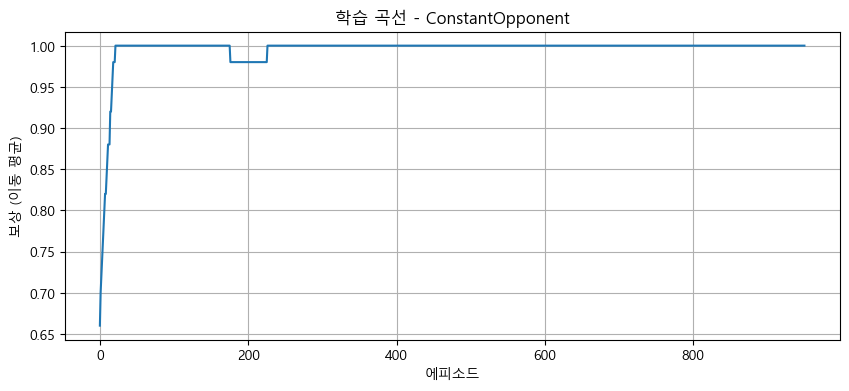


상대가 '가위'만 낼 때 학습된 정책의 행동 확률:
가위: 0.414
바위: 0.305
보: 0.282

상대가 '바위'만 내는 경우 학습 시작
Episode 500, Action: 2, Reward: 1
Episode 1000, Action: 2, Reward: 1


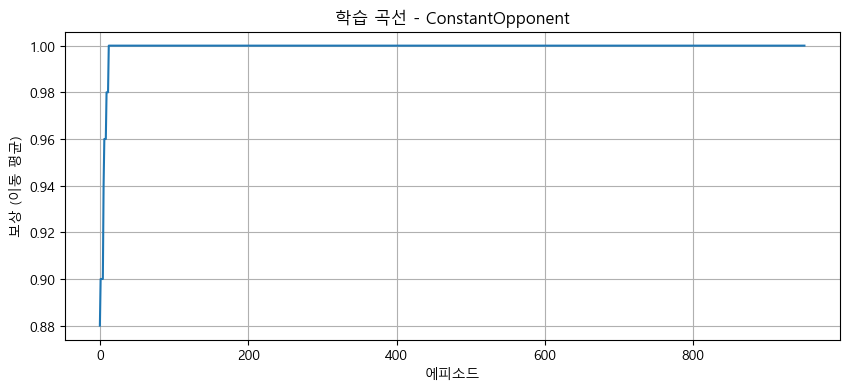


상대가 '바위'만 낼 때 학습된 정책의 행동 확률:
가위: 0.227
바위: 0.418
보: 0.354

상대가 '보'만 내는 경우 학습 시작
Episode 500, Action: 0, Reward: 1
Episode 1000, Action: 0, Reward: 1


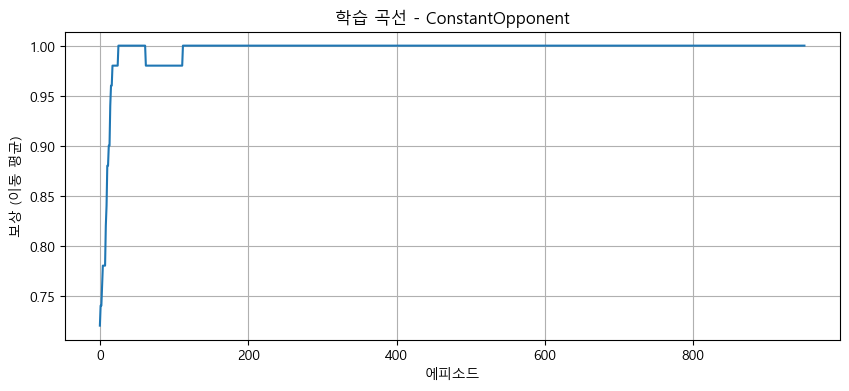


상대가 '보'만 낼 때 학습된 정책의 행동 확률:
가위: 0.354
바위: 0.310
보: 0.336


In [93]:
if __name__ == "__main__":
    actions = [("가위", 0), ("바위", 1), ("보", 2)]
    for name, action in actions:
        print(f"\n상대가 '{name}'만 내는 경우 학습 시작")
        policy_net = PolicyNetwork()
        opponent = ConstantOpponent(action)
        rewards = train_policy_gradient(policy_net, opponent)

        # 이동 평균 보상 계산
        window = 50
        smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

        # 학습 곡선 시각화
        plt.figure(figsize=(10, 4))
        plt.plot(smoothed_rewards)
        plt.title("학습 곡선 - ConstantOpponent")
        plt.xlabel("에피소드")
        plt.ylabel("보상 (이동 평균)")
        plt.grid()
        plt.show()
        
        # 테스트: 상대가 해당 행동만 냈을 때 정책의 확률 분포
        test_state = torch.zeros(3)
        test_state[action] = 1
        with torch.no_grad():
            action_probs = policy_net(test_state)
            print(f"\n상대가 '{name}'만 낼 때 학습된 정책의 행동 확률:")
            print(f"가위: {action_probs[0]:.3f}")
            print(f"바위: {action_probs[1]:.3f}")
            print(f"보: {action_probs[2]:.3f}")

Counting Based Opponent에 대해 학습 시작


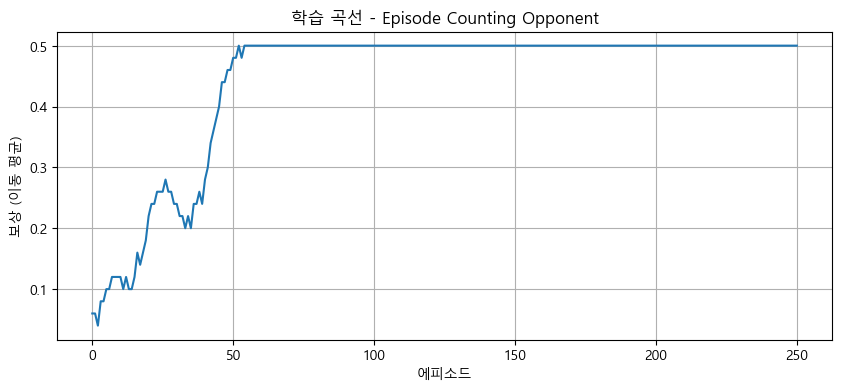


=== 학습 결과 분석 ===

상대방(EpisodeCountingOpponent)이 낸 패 카운트:
가위: 11회
바위: 140회
보: 149회


In [94]:
# counting based opponent와 학습 실행
if __name__ == "__main__":
    print("Counting Based Opponent에 대해 학습 시작")
    policy_net = PolicyNetwork()
    opponent = EpisodeCountingOpponent()
    rewards_2 = train_policy_gradient(policy_net, opponent, num_episodes=300, learning_rate=0.01)

    # 이동 평균 보상 계산
    window = 50
    smoothed_rewards = np.convolve(rewards_2, np.ones(window)/window, mode='valid')

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(smoothed_rewards)
    plt.title("학습 곡선 - Episode Counting Opponent")
    plt.xlabel("에피소드")
    plt.ylabel("보상 (이동 평균)")
    plt.grid()
    plt.show()
    
    # 테스트 및 결과 출력 부분
    print("\n=== 학습 결과 분석 ===")
        
    print("\n상대방(EpisodeCountingOpponent)이 낸 패 카운트:")
    opponent_counter = Counter(opponent.opponent_action_history)
    action_names = {SCISSORS: "가위", ROCK: "바위", PAPER: "보"}
    for action in [SCISSORS, ROCK, PAPER]:
        print(f"{action_names[action]}: {opponent_counter[action]}회")


Uniform Random Opponent에 대해 학습 시작


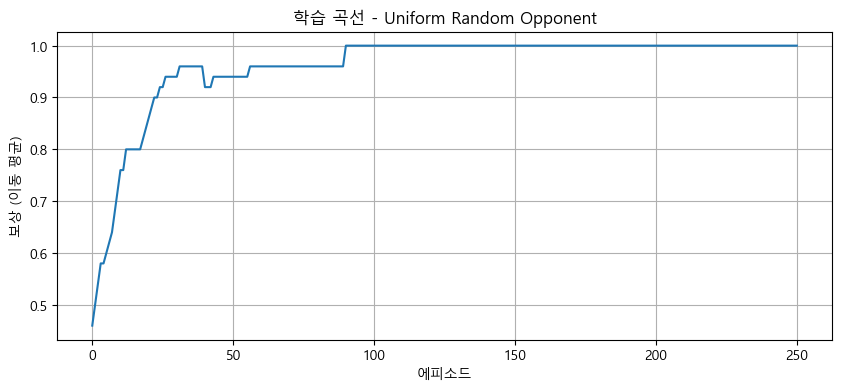


Uniform Random Opponent에 대해 학습된 정책의 행동 확률:
가위: 0.302
바위: 0.282
보: 0.416


In [95]:
if __name__ == "__main__":
    print("Uniform Random Opponent에 대해 학습 시작")
    policy_net = PolicyNetwork()
    opponent = UniformRandomOpponent()
    rewards_3 = train_policy_gradient(policy_net, opponent, num_episodes=300, learning_rate=0.01)

    # 이동 평균 보상 계산
    window = 50
    smoothed_rewards = np.convolve(rewards_3, np.ones(window)/window, mode='valid')

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(smoothed_rewards)
    plt.title("학습 곡선 - Uniform Random Opponent")
    plt.xlabel("에피소드")
    plt.ylabel("보상 (이동 평균)")
    plt.grid()
    plt.show()
    
    # 테스트: 랜덤이므로 임의로 하나 선택
    test_state = torch.zeros(3)

    with torch.no_grad():
        action_probs = policy_net(test_state)
        print("\nUniform Random Opponent에 대해 학습된 정책의 행동 확률:")
        print(f"가위: {action_probs[SCISSORS]:.3f}")
        print(f"바위: {action_probs[ROCK]:.3f}")
        print(f"보: {action_probs[PAPER]:.3f}")